# imports

In [14]:
import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.utils import to_categorical

# how many breeds and pictures we have

In [2]:
breed_list = os.listdir("images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


# label strings and numbers mapping

In [58]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})
print(label_maps_rev)

{0: 'n02085620-Chihuahua', 1: 'n02085782-Japanese_spaniel', 2: 'n02085936-Maltese_dog', 3: 'n02086079-Pekinese', 4: 'n02086240-Shih-Tzu', 5: 'n02086646-Blenheim_spaniel', 6: 'n02086910-papillon', 7: 'n02087046-toy_terrier', 8: 'n02087394-Rhodesian_ridgeback', 9: 'n02088094-Afghan_hound', 10: 'n02088238-basset', 11: 'n02088364-beagle', 12: 'n02088466-bloodhound', 13: 'n02088632-bluetick', 14: 'n02089078-black-and-tan_coonhound', 15: 'n02089867-Walker_hound', 16: 'n02089973-English_foxhound', 17: 'n02090379-redbone', 18: 'n02090622-borzoi', 19: 'n02090721-Irish_wolfhound', 20: 'n02091032-Italian_greyhound', 21: 'n02091134-whippet', 22: 'n02091244-Ibizan_hound', 23: 'n02091467-Norwegian_elkhound', 24: 'n02091635-otterhound', 25: 'n02091831-Saluki', 26: 'n02092002-Scottish_deerhound', 27: 'n02092339-Weimaraner', 28: 'n02093256-Staffordshire_bullterrier', 29: 'n02093428-American_Staffordshire_terrier', 30: 'n02093647-Bedlington_terrier', 31: 'n02093754-Border_terrier', 32: 'n02093859-Kerry_

# show some pictures

In [6]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    num_rows = (n_to_show + 3) // 4
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(num_rows, 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02085620-Chihuahua


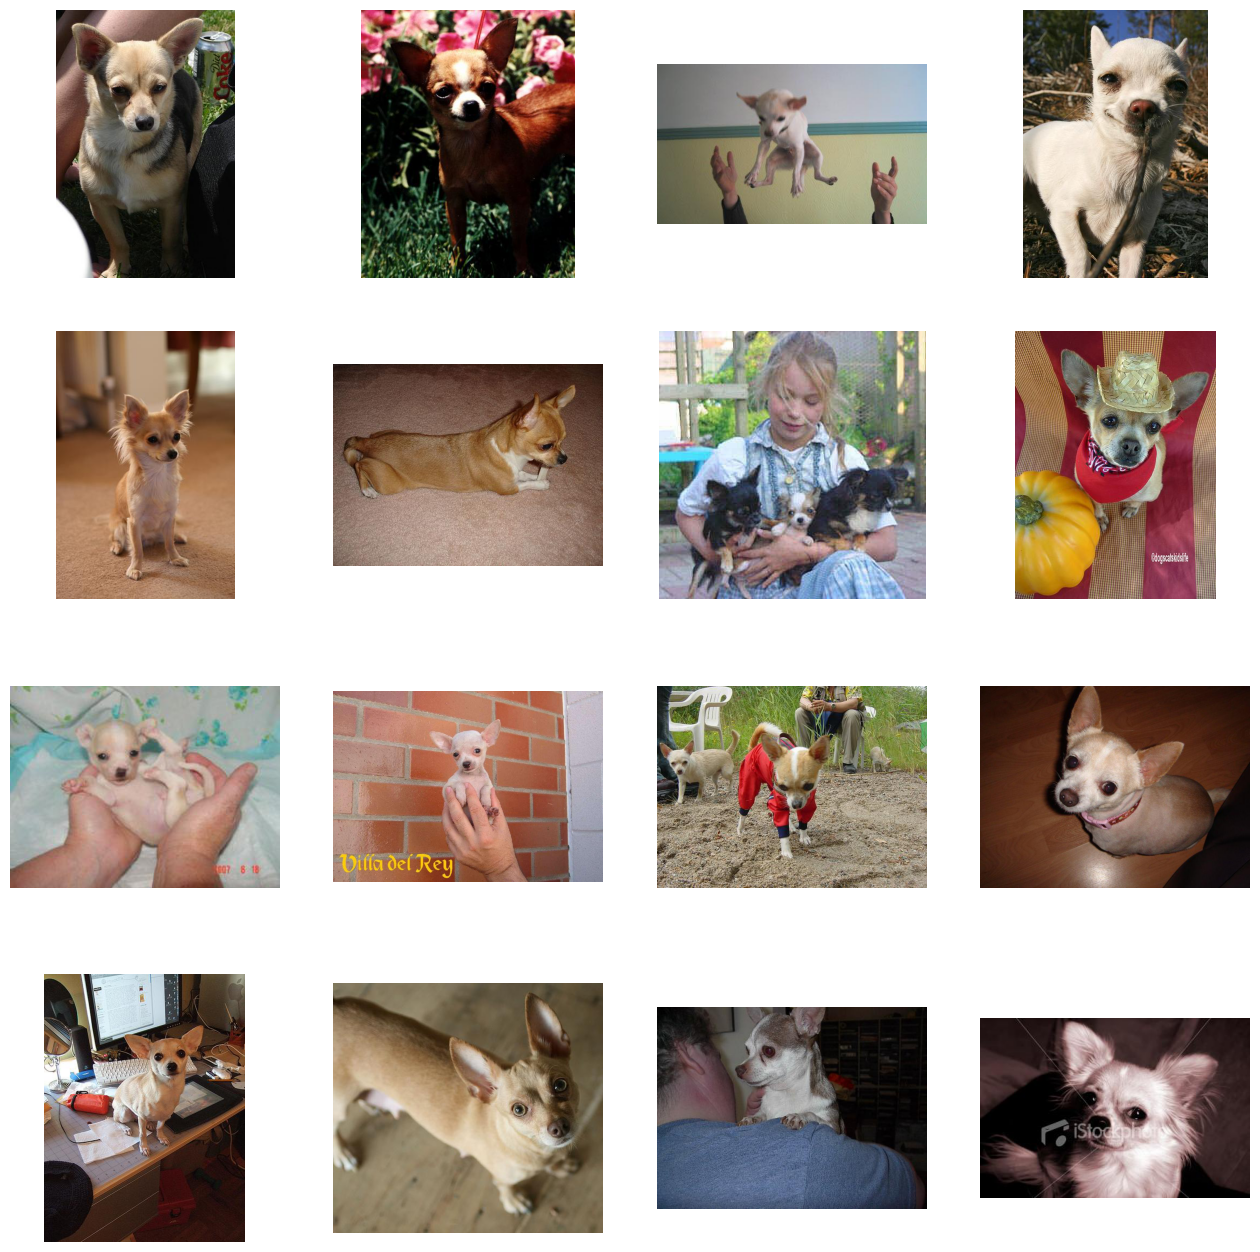

In [7]:
print(breed_list[0])
show_dir_images(breed_list[0], 16)

# crop and save pictures

In [8]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir('annotations/Annotation/{}'.format(breed)):
        img = Image.open('images/Images/{}/{}.jpg'.format(breed, file))
        tree = ET.parse('annotations/Annotation/{}/{}'.format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

Created 120 folders to store cropped images of the different breeds.
CPU times: total: 25.3 s
Wall time: 8min 14s


# prepare X and y

In [15]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "./data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = to_categorical(targets, num_classes=num_classes)

# image generator with augment

In [16]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

# train test split

In [17]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

# keras pretrain densenet121 model

In [18]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

# only train our last 6 layers

In [19]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [20]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [21]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20)

Epoch 1/20
547/547 [==============================] - 1274s 2s/step - loss: 3.2544 - acc: 0.2098 - val_loss: 1.3936 - val_acc: 0.5931
Epoch 2/20
547/547 [==============================] - 1281s 2s/step - loss: 2.1435 - acc: 0.4018 - val_loss: 1.1262 - val_acc: 0.6586
Epoch 3/20
547/547 [==============================] - 1277s 2s/step - loss: 1.9318 - acc: 0.4557 - val_loss: 1.0068 - val_acc: 0.6919
Epoch 4/20
547/547 [==============================] - 1312s 2s/step - loss: 1.8152 - acc: 0.4862 - val_loss: 0.9647 - val_acc: 0.6890
Epoch 5/20
547/547 [==============================] - 1314s 2s/step - loss: 1.7270 - acc: 0.5091 - val_loss: 0.9313 - val_acc: 0.7127
Epoch 6/20
547/547 [==============================] - 1295s 2s/step - loss: 1.6776 - acc: 0.5193 - val_loss: 0.9084 - val_acc: 0.7227
Epoch 7/20
547/547 [==============================] - 1181s 2s/step - loss: 1.6506 - acc: 0.5270 - val_loss: 0.9133 - val_acc: 0.7049
Epoch 8/20
547/547 [==============================] - 1202s 2s

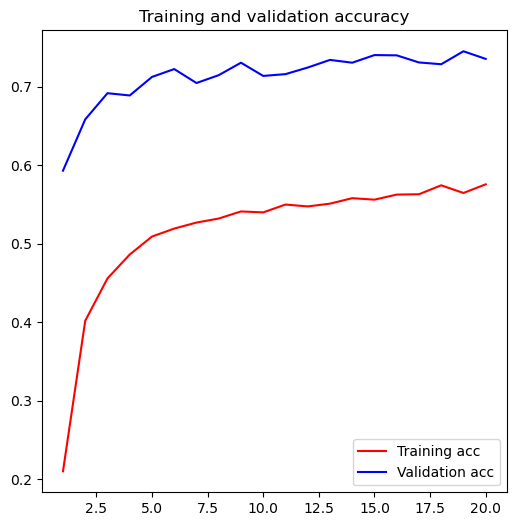

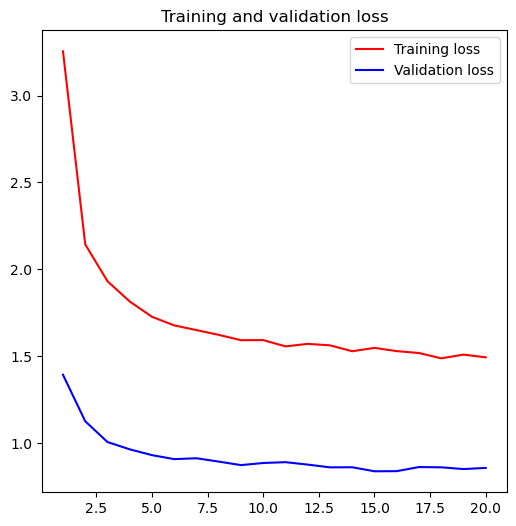

In [22]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

# now train all layers

In [23]:
for layer in model.layers[:]:
    layer.trainable = True

In [24]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [25]:
history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=val_gen, 
                              validation_steps=len(val_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 1.5089 - acc: 0.5713
Epoch 1: val_acc improved from -inf to 0.73405, saving model to dog_breed_classifier_model.h5
547/547 [==============================] - 1250s 2s/step - loss: 1.5089 - acc: 0.5713 - val_loss: 0.8638 - val_acc: 0.7340 - lr: 0.0010
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 1.4871 - acc: 0.5762
Epoch 2: val_acc improved from 0.73405 to 0.73664, saving model to dog_breed_classifier_model.h5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
547/547 [==============================] - 1355s 2s/step - loss: 1.4871 - acc: 0.5762 - val_loss: 0.8675 - val_acc: 0.7366 - lr: 0.0010
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 1.3151 - acc: 0.6208
Epoch 3: val_acc improved from 0.73664 to 0.76936, saving model to dog_breed_classifier_model.h5
547/547 [==============================] - 1364s 2s/step - loss: 1.3151 - acc: 0.6208 - v

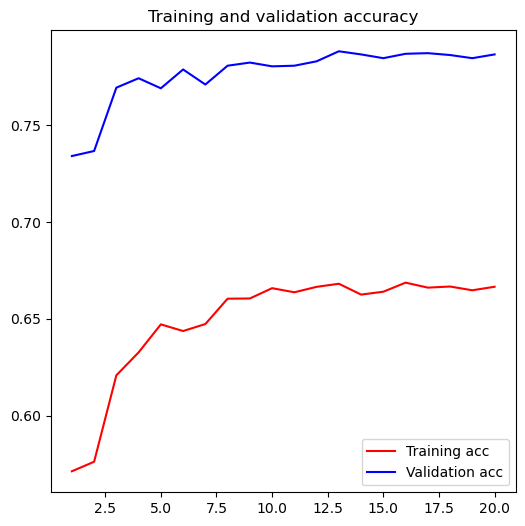

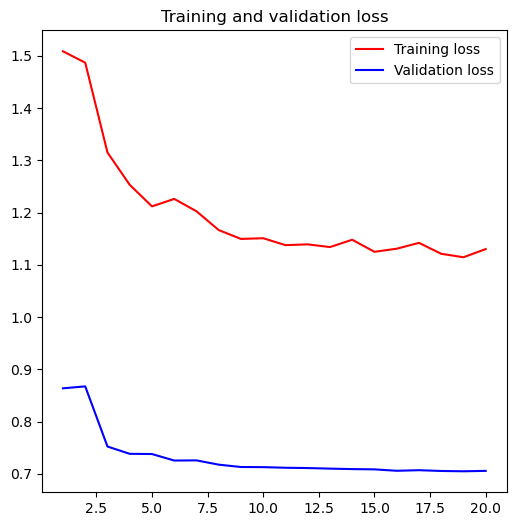

In [26]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [27]:
print(max(val_acc))

0.7881438136100769


# predict new images

download some dog images from pixabay for testing

In [82]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
#     print(probs.argsort()[0][::-1][0])
    for idx in probs.argsort()[0][::-1][:1]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 [==============================] - 0s 138ms/step
99.50% 	 golden_retriever


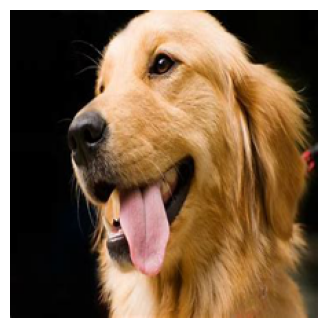

In [83]:
download_and_predict("doggo.jpg",
                     "doggo.jpg")

1/1 [==============================] - 0s 155ms/step
111


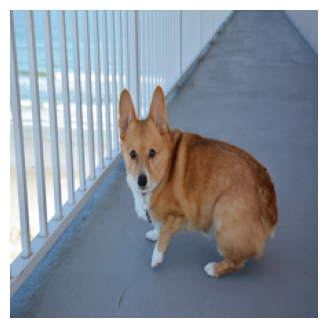

In [78]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 [==============================] - 0s 136ms/step
0


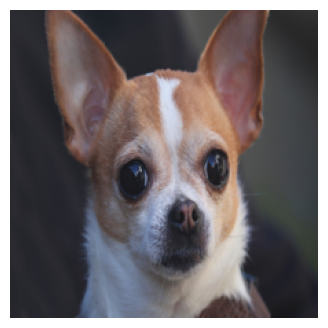

In [79]:
download_and_predict("https://cdn.pixabay.com/photo/2019/02/24/20/15/chihuahua-4018429_1280.jpg",
                     "test_3.jpg")

1/1 [==============================] - 0s 127ms/step
17


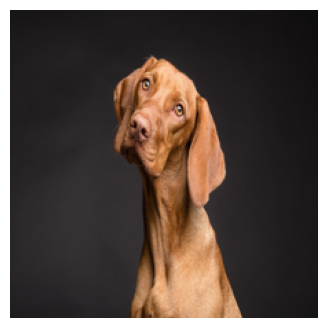

In [80]:
download_and_predict("https://cdn.pixabay.com/photo/2018/03/31/06/31/dog-3277416_1280.jpg",
                     "test_4.jpg")

1/1 [==============================] - 0s 92ms/step
94.10% 	 Labrador_retriever


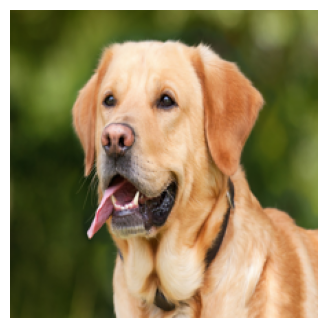

In [40]:
download_and_predict("https://cdn.pixabay.com/photo/2016/02/19/15/46/dog-1210559_1280.jpg",
                     "test_5.jpg")

In [34]:
model.save('doggo.h5')

# cleaning

In [26]:
!rm -rf data/* 

In [27]:
!rm -f test_*.jpg